In [24]:
import numpy as np
import networkx as nx
from itertools import product
import numba as nb
import copy
import matplotlib.pyplot as plt
from scipy import optimize

# Trotterized Quantum Annealing Initialization for the QAOA

In the following we provide a brief tutorial for the Trotterized Quantum Annealing (TQA) initialization for
the QAOA. The initialization allows to circumvent convergence in local sub-optimal optima and achieves 
similar performance as the best of $2^p$ random initilizations.
For details see: https://arxiv.org/abs/2101.05742

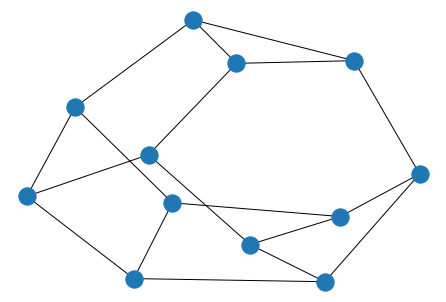

In [25]:
# Set everything up and show the graph
N = 12
seed = 42 
G = nx.random_regular_graph(d=3, n=N, seed=seed)
edges = nx.edge_betweenness(G).keys()
nodes = G.nodes
nx.draw(G)
initial_state = np.ones(2 ** N) / np.sqrt(2) ** N
# Create full Hilbertspace to use in creation of the Hamiltonians
H = np.array(list(product([1, -1], repeat=N))) 

In [26]:
# Fast Hadamard transformation

@nb.njit # Just in time compilation for massive speed-up
def fwht(a):
    h = 1
    tmp = a.copy()
    while 2 * h <= len(a):
        for i in range(0, len(a) - 1, h * 2):
            for j in range(i, i + h):
                x = tmp[j]
                y = tmp[j + h]
                tmp[j] = x + y
                tmp[j + h] = x - y
        h *= 2
    return tmp

def ifwht(a):
    return fwht(a) / len(a)

In [27]:
# Classical Hamiltonian, the ground state is the MaxCut solution
# we use the QAOA to find an approximation to the ground state variationally
def H_C():
    tmp = np.zeros(2**N)
    for i, j in edges:
        tmp += H[:, i] * H[:, j]
    return tmp

In [28]:
# Quantum Hamiltonian, the ground state is an equal superposition of all solutions, i.e. all possible graph cuts
def H_B():
    tmp = np.zeros(2**N)
    for i in nodes:
        tmp += H[:, i]
    return tmp

In [29]:
def qaoa_state(x):

    # Create the QAOA ansatz state, note that we use a fast Hadamard 
    # transformation (n log(n)) to keep the operators diagonal and use vector-vector 
    # multiplication rather than matrix-vector mutliplication where the 
    # matrix would be the matrix exponential of H_B which would be very slow

    beta, gamma = np.split(x, 2)
    state = copy.copy(initial_state)

    for g, b in zip(gamma, beta):

        state = np.exp(1j * g * H_C()) * state
        state = fwht(state)              # Fast Hadamard transformation
        state = np.exp(-1j * b * H_B()) * state
        state = ifwht(state)             # inverse Fast Hadamard transformation

    return state

In [30]:
def energy_expectation_value(state):
    return np.real(np.vdot(state, H_C() * state))

# Find the optimal Trotter time step

In [47]:
# Loop over different evolution times
time = np.linspace(0.1, 4, 20)

energies = []
for p in [3, 4]:
    energy = []
    for t_max in time: 
        
        dt = t_max / p
        t = dt * (np.arange(1, p + 1) - 0.5)
        gamma = (t / t_max) * dt
        beta = (1 - (t / t_max)) * dt
        x = np.concatenate((beta, gamma))
        energy.append(energy_expectation_value(qaoa_state(x)))

    energies.append(energy)

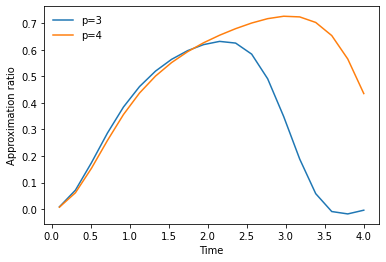

In [48]:
plt.plot(time, energies[0]/min(H_C()), label="p=3")
plt.plot(time, energies[1]/min(H_C()), label="p=4")
plt.xlabel('Time')
plt.ylabel('Approximation ratio')
plt.legend(frameon=False)

In [49]:
# Find optimal time 
idx = np.argmin(energies[1])
t_max = time[idx]
print(f'Optimal evolution time is {t_max} with an approximation ratio of {energies[1][idx]/min(H_C())}')

Optimal evolution time is 2.973684210526316 with an approximation ratio of 0.7270489057175235


# Launch QAOA from TQA initialization

In [50]:
# Fix initial beta and gamma values
p = 4
dt = t_max / p
t = dt * (np.arange(1, p + 1) - 0.5)
gamma = (t / t_max) * dt
beta = (1 - (t / t_max)) * dt
x0 = np.concatenate((beta, gamma))

In [53]:
func_to_optimize = lambda x: energy_expectation_value(qaoa_state(x))
result_tqa = optimize.minimize(func_to_optimize, x0, method='BFGS')

In [57]:
print(f'Final approximation ratio from TQA init. is {result_tqa.fun/min(H_C())}')

Final approximation ratio from TQA init. is 0.8216494294485007


In [58]:
# Quick comparison with a single QAOA run lauched from a random initialization
x0_random = np.concatenate((np.random.uniform(-np.pi/4, np.pi/4, p), np.random.uniform(-np.pi/2, np.pi/2, p)))
result_rand = optimize.minimize(func_to_optimize, x0_random, method='BFGS')

In [59]:
print(f'Final approximation ratio from random init. is {result_rand.fun/min(H_C())}')

Final approximation ratio from random init. is 0.7874762671579693


For a thorough performance comparison between random and TQA initialization, check out the paper.